In [6]:
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

import tifffile as tif

import xarray as xr
import os

from collections import defaultdict

from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [22]:
def extract_glcm(dir):
    out_dict = defaultdict(list)
    
    for file_name in os.listdir(dir):
        if not file_name.endswith('.nc'): continue

        xr_ds = xr.open_dataset(dir + file_name)
        for sigma0 in xr_ds.sigma0.transpose("pol", ...):   
            v = sigma0.values 
            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0,np.pi/2], levels=256,
                                symmetric=True, normed=True)
            
            out_dict['hom'].append(graycoprops(glcm, 'homogeneity')[0, 0])
            out_dict['dis'].append(graycoprops(glcm, 'dissimilarity')[0, 0])
            out_dict['cor'].append(graycoprops(glcm, 'correlation')[0, 0])
    return out_dict

In [25]:
noland_dir = './out/homogenuity/noland/'
wf_dir = './out/glcm_testset/mixed/wind_farm/'
noland_dict, wf_dict = extract_glcm(noland_dir), extract_glcm(wf_dir)
for k,v in noland_dict.items():
    print(k, v[:3], len(v), sep='\n')
    print()

for k,v in wf_dict.items():
    print(k, v[:3], len(v), sep='\n')
    print()

hom
[0.04538445646844163, 0.06812542282510972, 0.0390339019107781]
676

dis
[25.517230600920023, 30.43908728608197, 29.041910864522066]
676

cor
[0.102337439519482, -0.0009471357729734885, 0.0010567033942050978]
676

hom
[0.7387834394954663, 0.7626405537233888, 0.5113725828441612]
408

dis
[0.6827381417519695, 0.721887942486516, 1.666849001067936]
408

cor
[0.1381860278367832, 0.16035513479917984, 0.05147779781036986]
408



In [27]:
noland_X = np.column_stack((noland_dict['hom'], noland_dict['dis'], noland_dict['cor']))
#filter incorrect values
noland_X = noland_X[noland_X[:, 0] != 1]

wf_X = np.column_stack((wf_dict['hom'], wf_dict['dis'], wf_dict['cor']))
#filter incorrect values
wf_X = wf_X[wf_X[:, 0] != 1]

X, y = (np.concatenate((noland_X, wf_X)),
        np.concatenate((np.zeros_like(noland_X[:, 0]), np.ones_like(wf_X[:, 0]))))
X, y

(array([[ 4.53844565e-02,  2.55172306e+01,  1.02337440e-01],
        [ 6.81254228e-02,  3.04390873e+01, -9.47135773e-04],
        [ 3.90339019e-02,  2.90419109e+01,  1.05670339e-03],
        ...,
        [ 6.86495529e-01,  1.52905629e+00,  6.40522282e-03],
        [ 4.79600900e-01,  2.92771743e+00,  4.36055411e-01],
        [ 2.64303406e-01,  1.00853325e+01,  5.90092671e-01]]),
 array([0., 0., 0., ..., 1., 1., 1.]))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
svc = SVC()
svc = svc.fit(X_train, y_train)

In [32]:
svc.score(X_test, y_test)

0.930835734870317

In [35]:
with open('./out/homogenity_svc.pkl','wb') as f:
    pickle.dump(svc,f)

In [7]:
with open('./out/homogenity_svc.pkl', 'rb') as f:
    svc = pickle.load(f)

In [4]:
svc.score(X_test, y_test)

NameError: name 'X_test' is not defined

In [8]:
def load_sar(image_dir, hom_svc):
    sigma_dict = defaultdict(list)

    for file_name in os.listdir(image_dir):
        if not file_name.endswith('.nc'): continue
        
        xr_ds = xr.open_dataset(image_dir + file_name)
        for sigma0 in xr_ds.sigma0.transpose("pol", ...):
            v = sigma0.values 
            
            if np.isnan(v).any(): continue

            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)
            
            glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
            hom_dis_corr = [graycoprops(glcm, gt)[0, 0] for gt in glcm_types]
            assert hom_dis_corr[0] != 1, 'nans in sigma'
            
            sigma_dict['sigma'].append(v)
            sigma_dict['hom_dis_corr'].append(hom_dis_corr)
            
    return [s for s, p in 
            zip(sigma_dict['sigma'],
            hom_svc.predict(sigma_dict['hom_dis_corr']))
            if p == 0]

noland_dir = './out/homogenuity/noland/'
sigma_dict = load_sar(noland_dir, svc)

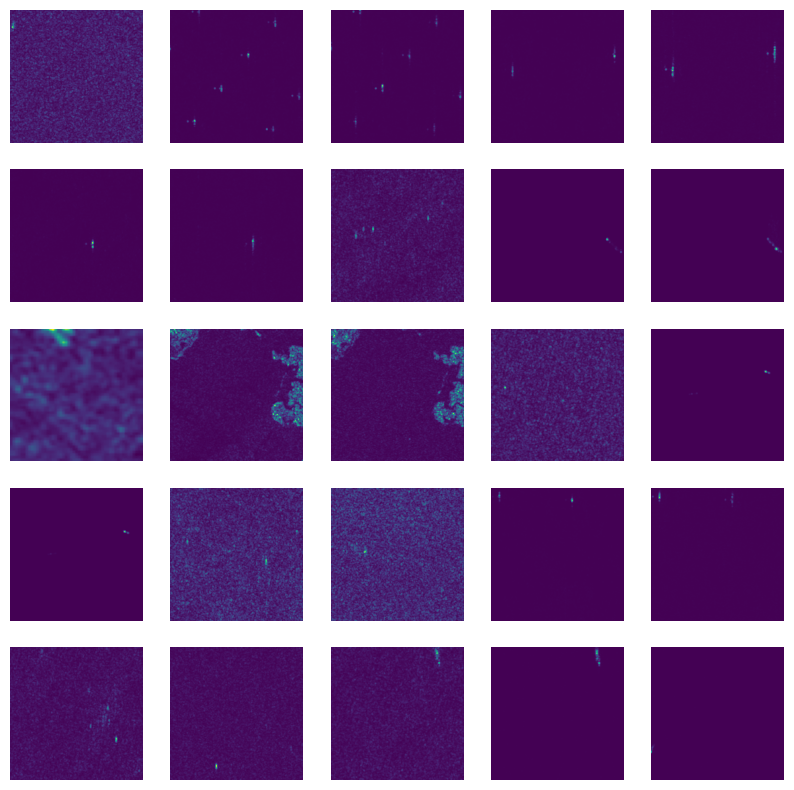

In [21]:
def miss_gen():
    for s, p in zip(sigma_dict['sigma'], svc.predict(sigma_dict['hom_dis_corr'])):
        if p == 1: 
            yield s
        
        
missclassified = list(miss_gen())      
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# Loop through the subplots and plot each image
for i, ax in enumerate(axes.flat):
    # Get the next image from the batch
    image = missclassified[i]
    
    # Plot the image on the current subplot
    ax.imshow(image)
    
    # Turn off the axis labels and ticks
    ax.set_axis_off()

# Show the plot
plt.show()

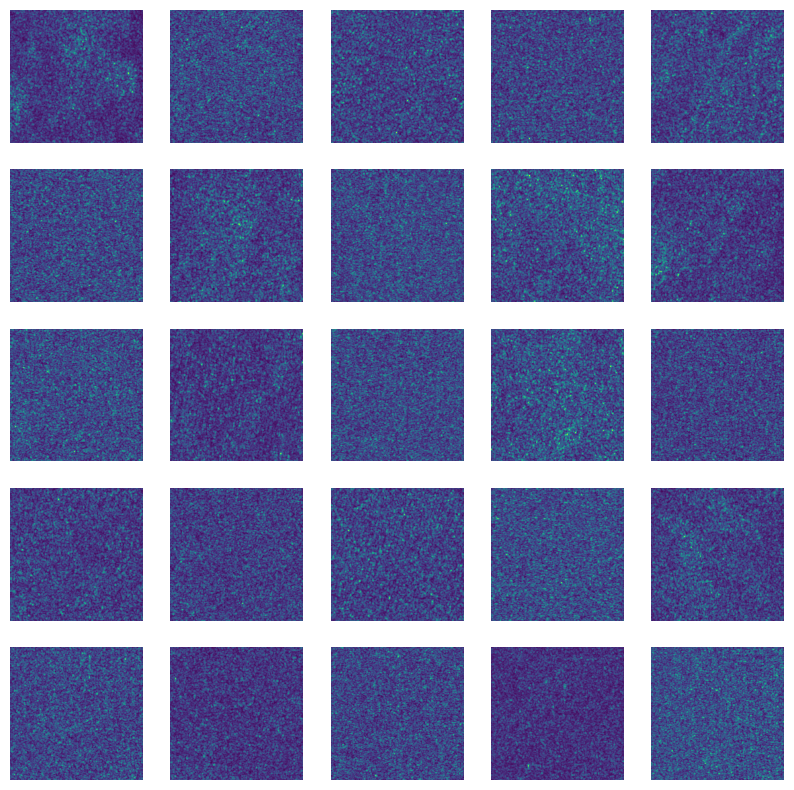

In [24]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# Loop through the subplots and plot each image
for i, ax in enumerate(axes.flat):
    # Get the next image from the batch
    image = sigma_dict[i]
    
    # Plot the image on the current subplot
    ax.imshow(image)
    
    # Turn off the axis labels and ticks
    ax.set_axis_off()

# Show the plot
plt.show()

In [9]:
write_folder = '../bouy_survey/1h_survey'
result_df_fn = 'result_df'

with open(os.path.join(write_folder, result_df_fn),'rb') as f_r:
    shore_survey_df = pickle.load(f_r)

In [6]:
shore_survey_df

bouy_file_name  bouy_longitude  bouy_latitude           bouy_time  \
0      GL_TS_MO_41159.nc      -76.948997      34.213001 2021-12-27 22:56:00   
1      GL_TS_MO_41159.nc      -76.948997      34.213001 2021-12-15 22:56:00   
2      GL_TS_MO_41159.nc      -76.948997      34.213001 2021-12-03 22:56:00   
3      GL_TS_MO_41159.nc      -76.948997      34.213001 2021-11-21 22:56:00   
4      GL_TS_MO_41159.nc      -76.948997      34.213001 2021-11-09 22:56:00   
...                  ...             ...            ...                 ...   
79879  GL_TS_MO_41025.nc      -75.362999      35.025002 2021-01-25 23:10:00   
79880  GL_TS_MO_41025.nc      -75.362999      35.025002 2021-01-20 23:00:00   
79881  GL_TS_MO_41025.nc      -75.362999      35.025002 2021-01-13 23:10:00   
79882  GL_TS_MO_41025.nc      -75.362999      35.025002 2021-01-08 23:00:00   
79883  GL_TS_MO_41025.nc      -75.362999      35.025002 2021-01-01 23:10:00   

       bouy_depth_index  bouy_depth bouy_variable_name  bouy_variable_value  \
0                     0         0.0               VHM0             1.109000   
1                     0         0.0               VHM0             0.849000   
2                     0         0.0               VHM0             0.809000   
3                     0         0.0               VHM0             1.249000   
4                     0         0.0               VHM0             1.199000   
...                 ...         ...                ...                  ...   
79879                 0        -4.1               WSPD             5.499000   
79880                 0        -4.1               WSPD             7.999000   
79881                 0        -4.1               WSPD             3.299000   
79882                 0        -4.1               WSPD            15.499001   
79883                 0        -4.1               WSPD             5.599000   

                                                 sar_url sar_mode  \
0      https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
1      https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
2      https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
3      https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
4      https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
...                                                  ...      ...   
79879  https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
79880  https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
79881  https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
79882  https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   
79883  https://datapool.asf.alaska.edu/GRD_HD/SA/S1A_...       IW   

      sar_polarization sar_platform      sar_start_time       sar_stop_time  \
0             [VV, VH]  Sentinel-1A 2021-12-27 23:05:44 2021-12-27 23:06:09   
1             [VV, VH]  Sentinel-1A 2021-12-15 23:05:45 2021-12-15 23:06:10   
2             [VV, VH]  Sentinel-1A 2021-12-03 23:05:46 2021-12-03 23:06:11   
3             [VV, VH]  Sentinel-1A 2021-11-21 23:05:46 2021-11-21 23:06:11   
4             [VV, VH]  Sentinel-1A 2021-11-09 23:05:46 2021-11-09 23:06:11   
...                ...          ...                 ...                 ...   
79879         [VV, VH]  Sentinel-1A 2021-01-25 23:06:03 2021-01-25 23:06:28   
79880         [VV, VH]  Sentinel-1A 2021-01-20 22:57:57 2021-01-20 22:58:26   
79881         [VV, VH]  Sentinel-1A 2021-01-13 23:06:03 2021-01-13 23:06:28   
79882         [VV, VH]  Sentinel-1A 2021-01-08 22:57:57 2021-01-08 22:58:26   
79883         [VV, VH]  Sentinel-1A 2021-01-01 23:06:04 2021-01-01 23:06:29   

                                         sar_coordinates  
0      [[-77.787575, 34.208473], [-77.43821, 32.70319...  
1      [[-77.787628, 34.208488], [-77.438286, 32.7032...  
2      [[-77.787346, 34.208439], [-77.438026, 32.7031...  
3      [[-77.787842, 34.208469], [-77.438553, 32.7032...  
4      [[-77.7882, 34.208534], [-77.438

In [7]:
sar_segment_df = pd.read_csv('./out/sar_segments/sar_segment_table.csv')
sar_segment_df

Unnamed: 0 out_name                                           sar_name  \
0           0     0.nc  S1A_IW_GRDH_1SDV_20211121T230546_20211121T2306...   
1           1     1.nc  S1A_IW_GRDH_1SDV_20211121T230546_20211121T2306...   
2           2     2.nc  S1A_IW_GRDH_1SDV_20211227T230544_20211227T2306...   
3           3     3.nc  S1A_IW_GRDH_1SDV_20211227T230544_20211227T2306...   
4           4     4.nc  S1A_IW_GRDH_1SDV_20211109T230546_20211109T2306...   
5           5     5.nc  S1A_IW_GRDH_1SDV_20211109T230546_20211109T2306...   
6           6     6.nc  S1A_IW_GRDH_1SDV_20211215T230545_20211215T2306...   
7           7     7.nc  S1A_IW_GRDH_1SDV_20211215T230545_20211215T2306...   
8           8     8.nc  S1A_IW_GRDH_1SDV_20211203T230546_20211203T2306...   
9           9     9.nc  S1A_IW_GRDH_1SDV_20211203T230546_20211203T2306...   

           bouy_name     lat     lon index_in_survey_df  
0  GL_TS_MO_41110.nc  34.142 -77.715            {42578}  
1  GL_TS_MO_41159.nc  34.213 -76.949                {3}  
2  GL_TS_MO_41110.nc  34.142 -77.715            {42572}  
3  GL_TS_MO_41159.nc  34.213 -76.949                {0}  
4  GL_TS_MO_41110.nc  34.142 -77.715            {42580}  
5  GL_TS_MO_41159.nc  34.213 -76.949                {4}  
6  GL_TS_MO_41110.nc  34.142 -77.715            {42574}  
7  GL_TS_MO_41159.nc  34.213 -76.949                {1}  
8  GL_TS_MO_41110.nc  34.142 -77.715            {42576}  
9  GL_TS_MO_41159.nc  34.213 -76.949                {2}

In [8]:
def get_value(file_name, variable = 'VHM0'):
    ix_for_file = sar_segment_df[
        sar_segment_df.out_name == file_name
    ].index_in_survey_df.iloc[0]
    int_ix = map(int, ix_for_file[1:-1].split(','))
    survey_for_file = shore_survey_df.loc[int_ix]
    
    variables_for_file = survey_for_file[
        survey_for_file.bouy_variable_name == variable
    ]
    
    if len(variables_for_file) < 1: return
    return variables_for_file.bouy_variable_value.iloc[0]

In [9]:
def load_sar(image_dir, hom_svc):
    sigma_dict = defaultdict(list)

    for file_name in os.listdir(image_dir):
        if not file_name.endswith('.nc'): continue
            
        value = get_value(file_name)
        
        xr_ds = xr.open_dataset(image_dir + file_name)
        for sigma0 in xr_ds.sigma0.transpose("pol", ...):
            v = sigma0.values 
            
            if np.isnan(v).any(): continue

            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)
            
            glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
            hom_dis_corr = [graycoprops(glcm, gt)[0, 0] for gt in glcm_types]
            assert hom_dis_corr[0] != 1, 'nans in sigma'
            
            sigma_dict['sigma'].append(v)
            sigma_dict['value'].append(value)
            sigma_dict['pol'].append(sigma0.pol.item()) 
            sigma_dict['hom_dis_corr'].append(hom_dis_corr)
            
    return [(s, v, p) for s, v, p, pred in 
            zip(
                sigma_dict['sigma'],
                sigma_dict['value'],
                sigma_dict['pol'],
                hom_svc.predict(sigma_dict['hom_dis_corr'])
            )
            if pred == 0]

seg_dir = './out/sar_segments/'
sigma_list = load_sar(seg_dir, svc)

In [22]:
agg_dict = defaultdict(list)
for s, v, p in sigma_list:
    agg_dict['sigma_mean'].append(s.mean())
    agg_dict['sigma_var'].append(s.var())
    agg_dict['sigma_mean_over_var'].append(s.mean() / s.var())

    agg_dict['value'].append(v)
    agg_dict['pol'].append(p)
agg_df = pd.DataFrame(agg_dict)
agg_df

sigma_mean  sigma_var  sigma_mean_over_var  value pol
0     0.016464   0.000098           167.539281  1.249  VV
1     0.000178   0.000002            76.137294  1.249  VH
2     0.000101   0.000002            43.034076  1.199  VH
3     0.022882   0.000195           117.317767  0.759  VV
4     0.000278   0.000006            49.980826  0.759  VH
5     0.001926   0.000009           212.672071  0.879  VV
6     0.000182   0.000005            34.357487  0.879  VH
7     0.029562   0.000236           125.071713  0.809  VV
8     0.000277   0.000003           103.920727  0.809  VH
9     0.001376   0.000007           193.469769  0.499  VV
10    0.000193   0.000006            33.791352  0.499  VH
11    0.014338   0.000074           193.484832  0.849  VV
12    0.000138   0.000002            56.804260  0.849  VH
13    0.039729   0.000407            97.733414  1.109  VV
14    0.000651   0.000003           209.705402  1.109  VH
15    0.045432   0.000556            81.652101  0.579  VV
16    0.000546   0.000006            87.441575  0.579  VH
17    0.000525   0.000005           100.856459  0.659  VV
18    0.000148   0.000005            27.567059  0.659  VH

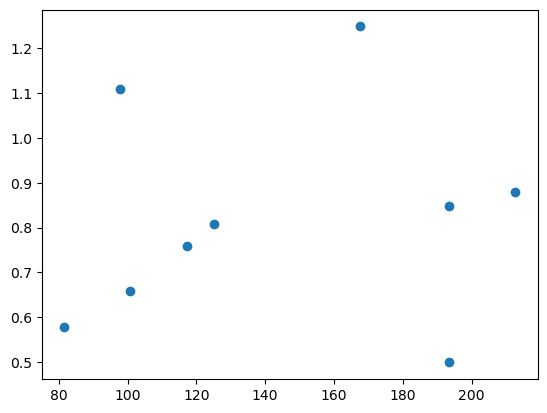

In [24]:
plt.scatter(agg_df[agg_df.pol == 'VV'].sigma_mean_over_var, agg_df[agg_df.pol == 'VV'].value)
plt.show()

1.2490000593243167


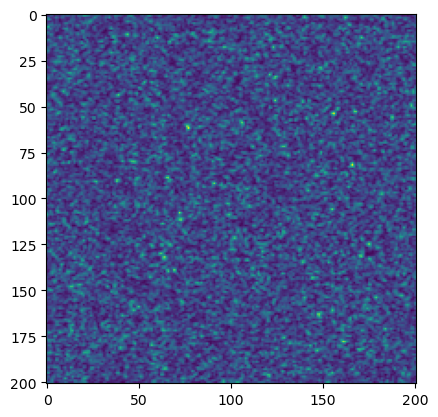

1.1990000569494441


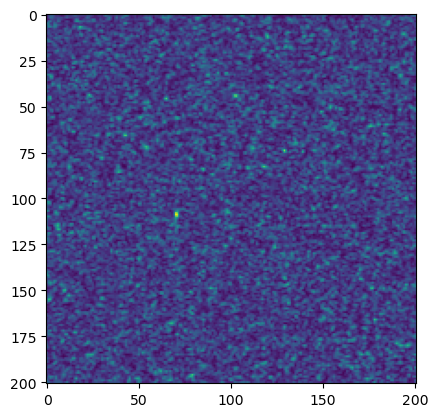

0.7590000360505655


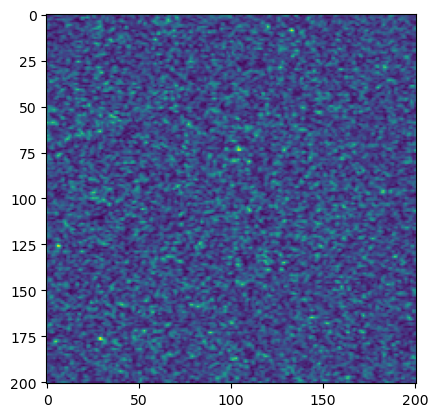

0.8790000417502597


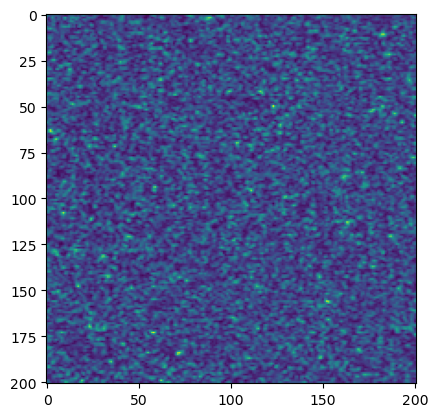

0.8090000384254381


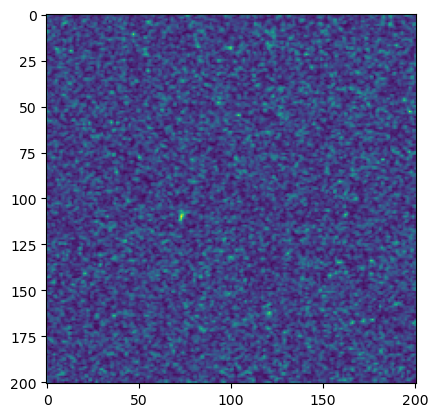

0.4990000237012282


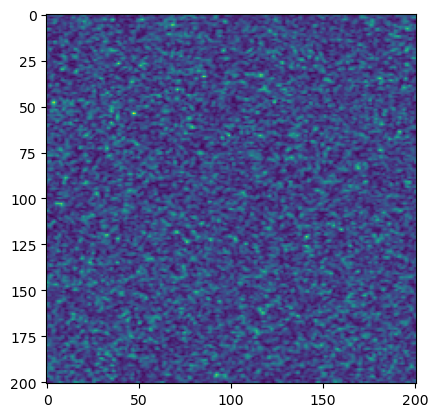

0.8490000403253362


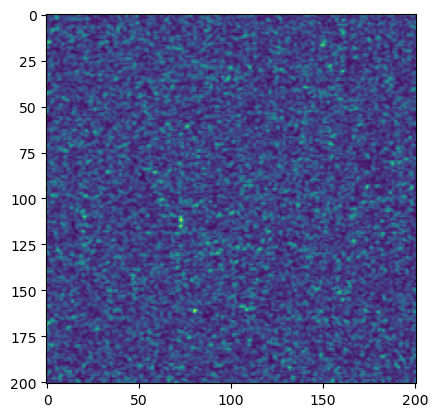

1.1090000526746735


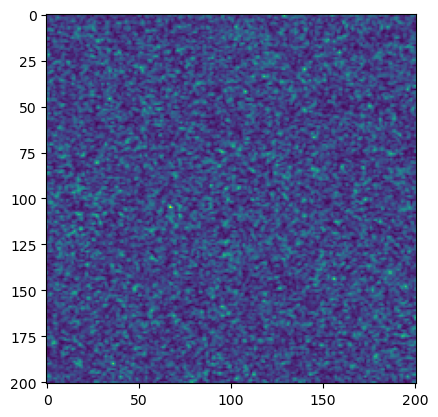

0.5790000275010243


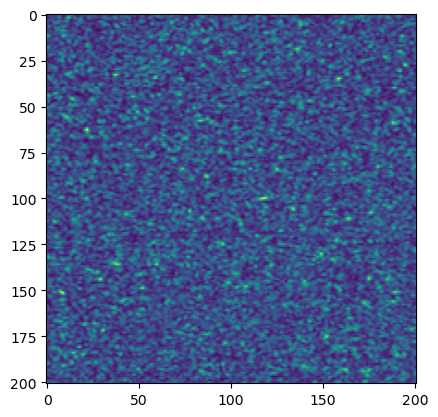

In [ ]:
from IPython.display import display

seg_dir = './out/sar_segments/'

for file_name in os.listdir(seg_dir):
    if not file_name.endswith('.nc'): continue
    print(get_value(file_name))
    
    xr_ds = xr.open_dataset(seg_dir + file_name)
    plt.imshow(xr_ds.sigma0.isel(pol=1).values)
    plt.show()


In [28]:
seg_dir = './out/sar_segments/'

def sar_gen():
    for file_name in os.listdir(seg_dir):
        if not file_name.endswith('.tif'): continue
        for pol, v in enumerate(tif.imread(seg_dir + file_name)):
            if np.isnan(v).any(): continue

            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)
            
            glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
            if svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]]) == 0:
                yield v, pol, file_name

In [13]:
sigma0, pol, name = next(sar_gen())

In [14]:
unpack_name = lambda name : name.split('.')[0].split('-')
sar_name, bouy_name, _ = unpack_name(name)
sar_name, bouy_name

('S1A_IW_GRDH_1SDV_20211226T173326_20211226T173351_041183_04E4CB_2659',
 'NO_TS_MO_ScheurWielingen')

In [15]:
url_df = shore_survey_df[shore_survey_df.sar_url.str.contains(sar_name)]
bouy_df = url_df[url_df.bouy_file_name.str.contains(bouy_name)]
bouy_df[bouy_df.bouy_variable_name == 'VHM0'].bouy_variable_value.item()

0.41000001947395504

100


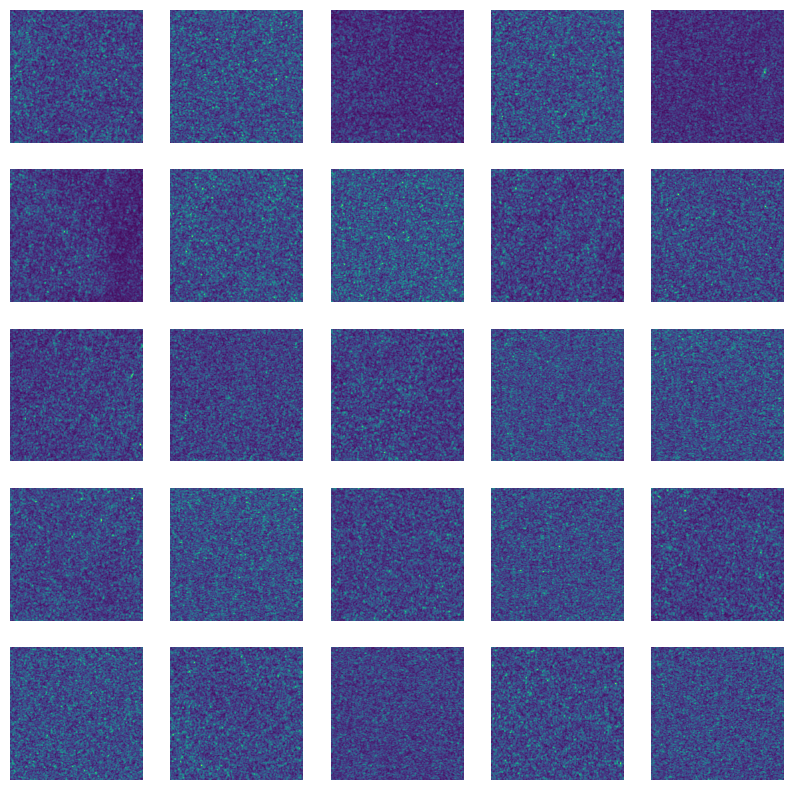

In [29]:
import itertools
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
images = list(map(lambda x : x[0], itertools.islice(sar_gen(), 100)))
print(len(images))
# Loop through the subplots and plot each image
for i, ax in enumerate(axes.flat):
    # Get the next image from the batch
    image = images[i]
    
    # Plot the image on the current subplot
    ax.imshow(image)
    
    # Turn off the axis labels and ticks
    ax.set_axis_off()

# Show the plot
plt.show()

In [10]:
unpack_name = lambda name : name.split('.')[0].split('-')

def get_value(name, variable_name = 'VHM0'):
    sar_name, bouy_name, _ = unpack_name(name)

    url_df = shore_survey_df[shore_survey_df.sar_url.str.contains(sar_name)]
    bouy_df = url_df[url_df.bouy_file_name.str.contains(bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

In [19]:
agg_dict = defaultdict(list)
for sigma0, pol, name in sar_gen():
    value = get_value(name)
    if value:
        agg_dict['sigma_mean'].append(sigma0.mean())
        agg_dict['sigma_var'].append(sigma0.var())
        agg_dict['sigma_mean_over_var'].append(sigma0.mean() / sigma0.var())
        
        #agg_dict['sigma_mean_dB'].append(10 * np.log10(sigma0.mean()))
        #agg_dict['sigma_mean_over_var'].append(sigma0.mean() / sigma0.var())
        

        agg_dict['value'].append(value)
        agg_dict['pol'].append(pol)
agg_df = pd.DataFrame(agg_dict)
agg_df

sigma_mean  sigma_var  sigma_mean_over_var  value  pol
0       0.019429   0.000118           164.035683   0.41    0
1      -0.000365   0.000003          -124.088354   0.41    1
2       0.011551   0.000054           215.049803   0.62    0
3      -0.000513   0.000003          -173.992125   0.62    1
4       0.042919   0.000615            69.766249   2.64    0
...          ...        ...                  ...    ...  ...
2505    0.016502   0.000095           172.908552   0.83    0
2506    0.032855   0.000314           104.593086   1.15    0
2507    0.000557   0.000003           193.251497   1.15    1
2508    0.037226   0.000372           100.044051   0.90    0
2509    0.000767   0.000004           186.829973   0.90    1

[2510 rows x 5 columns]

In [93]:
agg_df[agg_df.pol == 0].corr()

sigma_mean  sigma_var  sigma_mean_over_var     value  pol
sigma_mean             1.000000   0.939733            -0.837953  0.594152  NaN
sigma_var              0.939733   1.000000            -0.681869  0.614042  NaN
sigma_mean_over_var   -0.837953  -0.681869             1.000000 -0.536655  NaN
value                  0.594152   0.614042            -0.536655  1.000000  NaN
pol                         NaN        NaN                  NaN       NaN  NaN

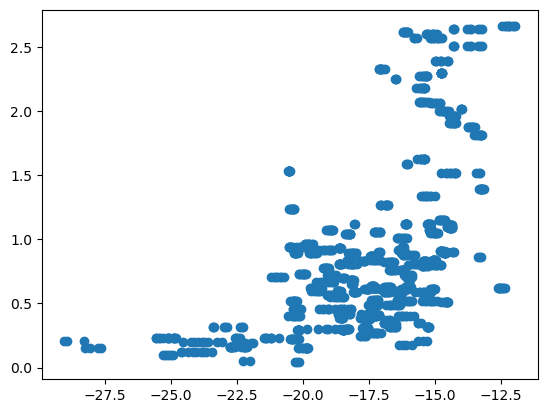

In [20]:
plt.scatter(10 * np.log10(agg_df[agg_df.pol == 0].sigma_mean), agg_df[agg_df.pol == 0].value)
plt.show()

In [21]:
seg_dir = './out/sar_segments/'

def sar_gen_only_center():
    for file_name in os.listdir(seg_dir):
        if not file_name.endswith('.tif'): continue
        if not file_name.split('.')[0][-1] == '0': continue
        for pol, v in enumerate(tif.imread(seg_dir + file_name)):
            if np.isnan(v).any(): continue

            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)
            
            glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
            if svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]]) == 0:
                yield v, pol, file_name

In [22]:
agg_only_center_dict = defaultdict(list)
for sigma0, pol, name in sar_gen_only_center():
    value = get_value(name)
    if value:
        agg_only_center_dict['sigma_mean'].append(sigma0.mean())
        agg_only_center_dict['sigma_var'].append(sigma0.var())
        agg_only_center_dict['sigma_mean_over_var'].append(sigma0.mean() / sigma0.var())

        agg_only_center_dict['value'].append(value)
        agg_only_center_dict['pol'].append(pol)
agg_only_center_df = pd.DataFrame(agg_only_center_dict)
agg_only_center_df

sigma_mean     sigma_var  sigma_mean_over_var  value  pol
0      0.042919  6.151809e-04            69.766249   2.64    0
1      0.033584  3.048590e-04           110.163730   0.91    0
2      0.000695  3.802168e-06           182.793823   0.91    1
3      0.056320  8.228865e-04            68.442236   0.62    0
4      0.018044  9.938941e-05           181.549487   0.38    0
..          ...           ...                  ...    ...  ...
285    0.000102  6.360359e-07           160.181499   0.16    1
286    0.014325  7.322214e-05           195.635234   0.46    0
287    0.000613  4.690009e-06           130.797710   0.46    1
288    0.020769  1.140431e-04           182.114408   0.59    0
289    0.000236  1.260193e-06           187.402558   0.59    1

[290 rows x 5 columns]

In [89]:
agg_only_center_df[agg_only_center_df.pol == 0].corr()

sigma_mean  sigma_var  sigma_mean_over_var     value  pol
sigma_mean             1.000000   0.936161            -0.845793  0.611390  NaN
sigma_var              0.936161   1.000000            -0.685881  0.632613  NaN
sigma_mean_over_var   -0.845793  -0.685881             1.000000 -0.544020  NaN
value                  0.611390   0.632613            -0.544020  1.000000  NaN
pol                         NaN        NaN                  NaN       NaN  NaN

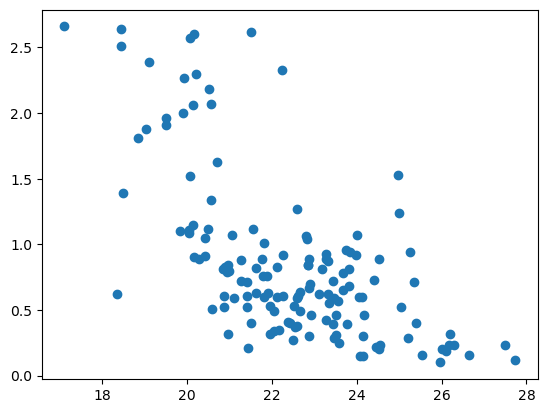

In [24]:
plt.scatter(10 * np.log10(agg_only_center_df[agg_only_center_df.pol == 0].sigma_mean_over_var), agg_only_center_df[agg_only_center_df.pol == 0].value)
plt.show()

In [100]:
Counter(n.split('-')[1] for n in os.listdir(seg_dir) if n.endswith('.tif'))

Counter({'NO_TS_MO_LichteilandGoeree2': 90,
         'NO_TS_MO_ScheurWielingen': 81,
         'NO_TS_MO_Oosterschelde4': 90,
         'NO_TS_MO_6200170': 90,
         'NO_TS_MO_ZeebruggeDam': 58,
         'NO_TS_MO_Schouwenbank': 90,
         'NO_TS_MO_Europlatform2': 90,
         'NO_TS_MO_BolVanHeist': 90,
         'NO_TS_MO_EurogeulE13': 90,
         'NO_TS_MO_Brouwershavensegat': 90,
         'NO_TS_MO_Akkaert': 90,
         'NO_TS_MO_Raversijde2': 54,
         'NO_TS_MO_OostendNorth': 90,
         'NO_TS_MO_Trapegeer': 90,
         'NO_TS_MO_Europlatform3': 90,
         'NO_TS_MO_EurogeulDWE': 90,
         'NO_TS_MO_ThorntonbankSouth': 90,
         'NO_TS_MO_OostendPoortens': 90,
         'NO_TS_MO_IJmuidenMunitiestort2': 63,
         'NO_TS_MO_Schouwenbank2': 90,
         'NO_TS_MO_LichteilandGoeree1': 90,
         'NO_TS_MO_WielingenNoord': 90,
         'NO_TS_MO_Oosterschelde11': 90,
         'NO_TS_MO_Roompotsluis': 90,
         'NO_TS_MO_ZeebruggePortBuoy': 50,
         'NO_T